<a href="https://colab.research.google.com/github/luiseduaardo/PneuModel/blob/main/notebooks/treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/luiseduaardo/PneuModel.git
%cd PneuModel

Cloning into 'PneuModel'...
remote: Enumerating objects: 5945, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 5945 (delta 18), reused 9 (delta 3), pack-reused 5901 (from 3)
Receiving objects: 100% (5945/5945), 1.26 GiB | 18.16 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/PneuModel


In [2]:
!pip install -r requirements.txt

In [3]:
import os
import zipfile

FILE_ID = '1YLeauT4Kwl6EpdpcUesU6WdE5cA12Y4K'
ZIP_NAME = 'ligia-compviz.zip'
EXTRACT_PATH = './dataset'

def download_and_extract():
    if os.path.exists(ZIP_NAME):
        os.remove(ZIP_NAME)

    command = f"""
      FILEID="{FILE_ID}";
      FILENAME="{ZIP_NAME}";
      wget --quiet --save-cookies cookies.txt --keep-session-cookies \
      "https://drive.google.com/uc?export=download&id=$FILEID" -O response.html;
      UUID=$(grep -o 'name="uuid" value="[^"]*' response.html | sed 's/.*value="//');
      wget --load-cookies cookies.txt \
      "https://drive.usercontent.google.com/download?id=$FILEID&export=download&confirm=t&uuid=$UUID" \
      -O "$FILENAME";
      rm -f cookies.txt response.html;
    """

    os.system(command)

    if os.path.exists(ZIP_NAME) and zipfile.is_zipfile(ZIP_NAME):
        print("Arquivo baixado com sucesso. Extraindo...")
        with zipfile.ZipFile(ZIP_NAME, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print(f"✅ Dataset pronto em {EXTRACT_PATH}")

download_and_extract()

Arquivo baixado com sucesso. Extraindo...
✅ Dataset pronto em ./dataset


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

path_treinamento = "./dataset/train/train"

# treino
train_generator = train_datagen.flow_from_directory(
    path_treinamento,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

labels = train_generator.classes
weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))

# validação
val_generator = val_datagen.flow_from_directory(
    path_treinamento,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [tf.keras.metrics.AUC(name='auc')]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [9]:
checkpoint_path = './modelo.keras'

early_stop = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    mode='max'
)

callbacks_list = [early_stop, checkpoint, reduce_lr]

In [10]:
# treino warm-up
history = model.fit(
    train_generator,
    epochs=20, # Limite alto, mas geralmente o EarlyStopping para antes
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - auc: 0.9021 - loss: 0.3774 - val_auc: 0.9782 - val_loss: 0.5422 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.9727 - loss: 0.2104 - val_auc: 0.9805 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.9786 - loss: 0.1837 - val_auc: 0.9846 - val_loss: 0.4458 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.9783 - loss: 0.1849 - val_auc: 0.9835 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.9828 - loss: 0.1634 - val_auc: 0.9883 - val_loss: 0.2868 - learning_rate: 0.0010
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.9809 - loss: 0.1759 - val_auc: 0.9898 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.9817 - loss: 0.1708 - val_auc: 0.9904 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 8/20
66/66 ━━

In [11]:
# fine tuning
base_model.trainable = True

for layer in base_model.layers[:-30]: # deixa apenas as últimas 30 camadas treináveis
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # baixa lr para não destruir o aprendizado anterior
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

history_finetuning = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop],
    class_weight=class_weights
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - auc: 0.9064 - loss: 0.9599 - val_auc: 0.8079 - val_loss: 3.6187
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9704 - loss: 0.2830 - val_auc: 0.5049 - val_loss: 6.4697
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9786 - loss: 0.2203 - val_auc: 0.8891 - val_loss: 0.7318
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9773 - loss: 0.2299 - val_auc: 0.9506 - val_loss: 0.8249
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9802 - loss: 0.2024 - val_auc: 0.9623 - val_loss: 0.8070
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9883 - loss: 0.1353 - val_auc: 0.9886 - val_loss: 0.1677
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9875 - loss: 0.1498 - val_auc: 0.9761 - val_loss: 0.4094
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9786 - loss: 0.2034 - val_auc: 0.9844 - val_loss: 0.1307
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.9842 - loss:

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

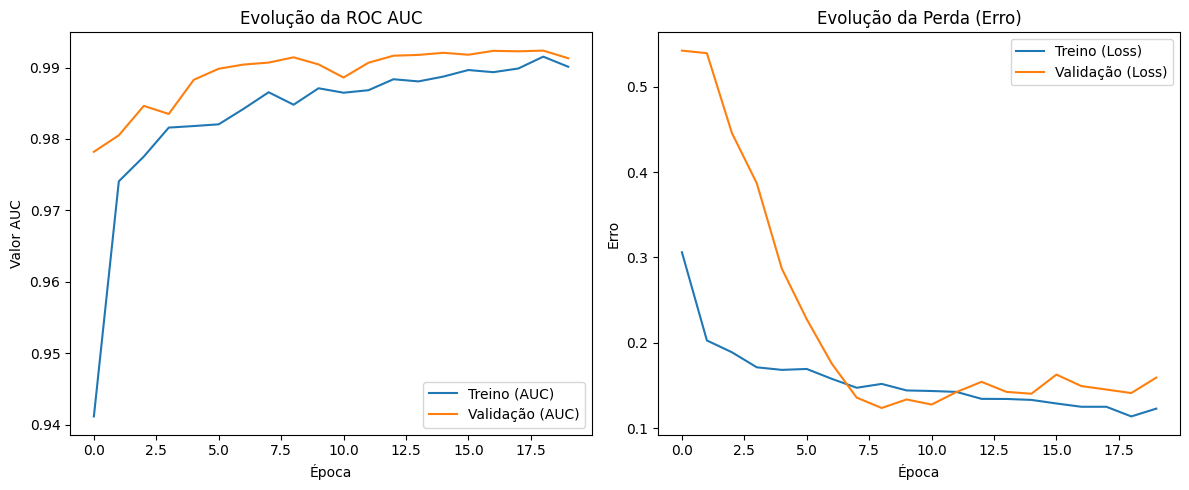

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Treino (AUC)')
plt.plot(history.history['val_auc'], label='Validação (AUC)')
plt.title('Evolução da ROC AUC')
plt.xlabel('Época')
plt.ylabel('Valor AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Evolução da Perda (Erro)')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.legend()

plt.tight_layout()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 698ms/step


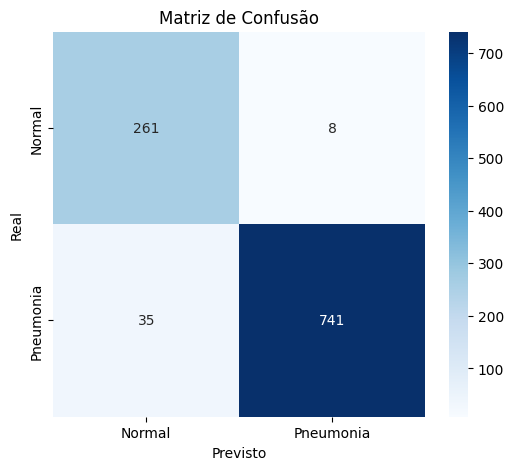

              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92       269
   Pneumonia       0.99      0.95      0.97       776

    accuracy                           0.96      1045
   macro avg       0.94      0.96      0.95      1045
weighted avg       0.96      0.96      0.96      1045



In [14]:
val_generator.reset()
predictions = model.predict(val_generator)

y_pred = (predictions > 0.5).astype(int)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

In [15]:
from google.colab import drive

drive.mount('/content/drive')

target_dir = '/content/drive/MyDrive/PneuModel/'
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

import shutil
shutil.copy('./modelo.keras', target_dir + 'modelo.keras')
print(f"✅ Modelo salvo em {target_dir}")

Mounted at /content/drive
✅ Modelo salvo em /content/drive/MyDrive/PneuModel/
